In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
pd.set_option('display.max_columns', None)
from IPython.display import display

from pybaseball import statcast_pitcher
from pybaseball import playerid_lookup

In [2]:
df = pd.read_csv("../data/kershaw.csv")
df['year'] = pd.DatetimeIndex(df['game_date']).year  # separate year from date
df['month'] = pd.DatetimeIndex(df['game_date']).month
df_2008 = df[df['year']==2008]
df_2017_season = df[(df['year']==2017) & (df['month'] >= 4)]

/var/folders/w0/3ttb6cs14rq8l4ggd5r1v9440000gn/T/ipykernel_70074/806051061.py:1: DtypeWarning: Columns (43,87,88) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/kershaw.csv")


In [174]:
states = {(0,0): 0,
          (1,0): 1,
          (2,0): 2,
          (3,0): 3,
          (0,1): 4,
          (0,2): 5,
          (1,1): 6,
          (1,2): 7,
          (2,1): 8,
          (2,2): 9,
          (3,1): 10,
          (3,2): 11,
          "Out": 12, 
          "Single": 13, 
          "Double": 14, 
          "Triple": 15, 
          "HR": 16, 
          "Walk": 17}
pitch_count_labels = [
    "(0,0)",
    "(1,0)",
    "(2,0)",
    "(3,0)",
    "(0,1)",
    "(0,2)",
    "(1,1)",
    "(1,2)",
    "(2,1)",
    "(2,2)",
    "(3,1)",
    "(3,2)",
    "Out", 
    "Single",
    "Double",
    "Triple",
    "HR",
    "Walk"
]

In [175]:
df_simple = df_2017_season.filter(items=['balls',
                             'strikes',
                             'events',
                             'description',
                             'game_date'])
df_simple = df_simple.iloc[::-1] # reverse order from earliest to latest
non_terminal_states = list(zip(df_simple.balls, df_simple.strikes))
df_simple['non_terminal_states'] = non_terminal_states
df_simple = df_simple.reset_index()

#create unique list of names
unique_games = df_simple.game_date.unique()
DataFrameDict = {elem : pd.DataFrame() for elem in unique_games}

for key in DataFrameDict.keys():
    DataFrameDict[key] = df_simple[:][df_simple.game_date == key]

In [182]:
def get_pitch_sequence(df_game):
    pitch_seq_swing = []
    pitch_seq_stand = []
    for i, row in df_game.iterrows():
        event = row['events']

        # if swing
        if (row['description'] == 'foul' or 
             row['description'] == 'swinging_strike' or 
             row['description'] == 'foul_tip' or
             row['description'] == 'swinging_strike_blocked' or
             row['description'] == 'foul_bunt' or 
             row['description'] == 'missed_bunt' or 
             row['description'] == 'hit_into_play'):
            
            # no outcome, add non-terminal state
            if str(event) == "nan":
                pitch_seq_swing.append(states[row['non_terminal_states']])
            # if Out, add terminal state
            elif (str(event) == "strikeout" or 
                    str(event) == "field_out" or 
                    str(event) == "grounded_into_double_play" or 
                    str(event) == "fielders_choice_out" or 
                    str(event) == "sac_fly" or 
                    str(event) == "force_out" or 
                    str(event) == "sac_bunt" or 
                    str(event) == "caught_stealing_2b"):
                pitch_seq_swing.append(states["Out"])
            elif (str(event) == "single"):
                pitch_seq_swing.append(states["Single"])
            elif (str(event) == "double"):
                pitch_seq_swing.append(states["Double"])
            elif (str(event) == "triple"):
                pitch_seq_swing.append(states["Triple"])
            elif (str(event) == "home_run"):
                pitch_seq_swing.append(states["HR"])
            elif (str(event) == "walk"):
                pitch_seq_swing.append(states["Walk"])

        # elif stand
        elif (row['description'] == 'called_strike' or 
              row['description'] == 'ball' or 
              row['description'] == 'blocked_ball'):

            # no outcome, add non-terminal state
            if str(event) == "nan":
                pitch_seq_stand.append(states[row['non_terminal_states']])
            # if Out, add terminal state
            elif (str(event) == "strikeout" or 
                    str(event) == "field_out" or 
                    str(event) == "grounded_into_double_play" or 
                    str(event) == "fielders_choice_out" or 
                    str(event) == "sac_fly" or 
                    str(event) == "force_out" or 
                    str(event) == "sac_bunt" or 
                    str(event) == "caught_stealing_2b"):
                pitch_seq_stand.append(states["Out"])
            elif (str(event) == "single"):
                pitch_seq_stand.append(states["Single"])
            elif (str(event) == "double"):
                pitch_seq_stand.append(states["Double"])
            elif (str(event) == "triple"):
                pitch_seq_stand.append(states["Triple"])
            elif (str(event) == "home_run"):
                pitch_seq_stand.append(states["HR"])
            elif (str(event) == "walk"):
                pitch_seq_stand.append(states["Walk"])
            
    return pitch_seq_swing, pitch_seq_stand

In [183]:
df_simple.description.unique(),  df_simple.events.unique()

(array(['called_strike', 'foul', 'ball', 'swinging_strike',
        'hit_into_play', 'blocked_ball', 'foul_tip',
        'swinging_strike_blocked', 'foul_bunt', 'missed_bunt'],
       dtype=object),
 array([nan, 'strikeout', 'field_error', 'single', 'field_out', 'home_run',
        'triple', 'double', 'fielders_choice_out', 'walk',
        'grounded_into_double_play', 'sac_fly', 'force_out', 'double_play',
        'caught_stealing_2b', 'sac_bunt', 'fielders_choice'], dtype=object))

In [184]:
def count_transitions(pitch_seq):
    n = 1+ max(pitch_seq) #number of states
    M = [[0]*n for _ in range(n)]
    for (i,j) in zip(pitch_seq,pitch_seq[1:]):
        M[i][j] += 1
    return np.array(M)

In [185]:
def get_probabilities(m):
    for row in m:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
    return m

In [186]:
all_swing_matrices = []
all_stand_matrices = []

for game_date, game_df in DataFrameDict.items():
    pitch_sequence_swing, pitch_sequence_stand = get_pitch_sequence(game_df)

    m_swing = count_transitions(pitch_sequence_swing)
    m_stand = count_transitions(pitch_sequence_stand)

    pad_len_swing = 18 - len(m_swing)
    pad_len_stand = 18 - len(m_stand)

    m_swing = np.pad(m_swing, (0, pad_len_swing), mode="constant")
    m_stand = np.pad(m_stand, (0, pad_len_stand), mode="constant")

    all_swing_matrices.append(m_swing)
    all_stand_matrices.append(m_stand)
    break

all_swing_matrices = np.array(all_swing_matrices)
all_stand_matrices = np.array(all_stand_matrices) 

M_swing = sum(all_swing_matrices)
M_stand = sum(all_stand_matrices)

M_swing = get_probabilities(M_swing.tolist())
M_stand = get_probabilities(M_stand.tolist())

M_swing = np.array(M_swing)
M_stand = np.array(M_stand)

print("Pitch transition probability under swing")
for row in M_swing: print(' '.join('{0:.2f}'.format(x) for x in row))
print("")
print("Pitch transition probability under stand")
for row in M_stand: print(' '.join('{0:.2f}'.format(x) for x in row))

Pitch transition probability under swing
0.25 0.00 0.00 0.00 0.50 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.25 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.40 0.00 0.00 0.00 0.00 0.00 0.60 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.50 0.00 0.00 0.00 0.50 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.25 0.00 0.00 0.00 0.00 0.25 0.00 0.25 0.00 0.00 0.00 0.00 0.25 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.50 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.50 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.75 0.25 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.50 0.50 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00

In [191]:
df_simple[df_simple['game_date'] == '2017-04-03'].head(50)

,index,balls,strikes,events,description,game_date,non_terminal_states
0,29771,0,0,NaN,called_strike,2017-04-03,"(0, 0)"
1,29770,0,1,NaN,foul,2017-04-03,"(0, 1)"
2,29769,0,2,NaN,ball,2017-04-03,"(0, 2)"
3,29768,1,2,strikeout,swinging_strike,2017-04-03,"(1, 2)"
4,29767,0,0,NaN,ball,2017-04-03,"(0, 0)"
5,29766,1,0,NaN,swinging_strike,2017-04-03,"(1, 0)"
6,29765,1,1,NaN,swinging_strike,2017-04-03,"(1, 1)"
7,29764,1,2,field_error,hit_into_play,2017-04-03,"(1, 2)"
8,29763,0,0,NaN,ball,2017-04-03,"(0, 0)"
9,29762,1,0,NaN,blocked_ball,2017-04-03,"(1, 0)"


In [192]:
df_simple[df_simple['game_date'] == '2017-04-03'].tail(50)

,index,balls,strikes,events,description,game_date,non_terminal_states
34,29737,3,2,field_out,hit_into_play,2017-04-03,"(3, 2)"
35,29736,0,0,NaN,foul,2017-04-03,"(0, 0)"
36,29735,0,1,NaN,foul,2017-04-03,"(0, 1)"
37,29734,0,2,NaN,ball,2017-04-03,"(0, 2)"
38,29733,1,2,NaN,foul,2017-04-03,"(1, 2)"
39,29732,1,2,NaN,foul,2017-04-03,"(1, 2)"
40,29731,1,2,NaN,foul,2017-04-03,"(1, 2)"
41,29730,1,2,NaN,foul,2017-04-03,"(1, 2)"
42,29729,1,2,strikeout,called_strike,2017-04-03,"(1, 2)"
43,29728,0,0,NaN,called_strike,2017-04-03,"(0, 0)"


## Visualization

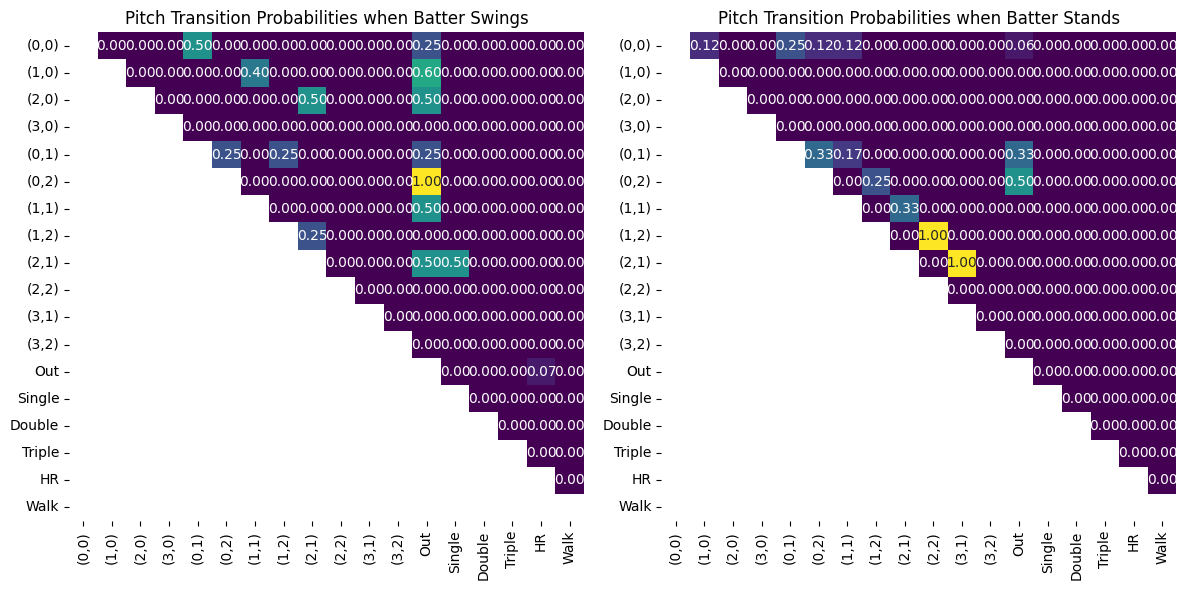

In [187]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns for the two heatmaps

matrix = np.tril(np.ones_like(M_swing))

# Plot the first heatmap (array1)
sns.heatmap(M_swing, 
            ax=axes[0], 
            cmap='viridis', 
            annot=True, 
            fmt='.2f', 
            cbar=False, 
            mask=matrix,
            xticklabels=pitch_count_labels,
            yticklabels=pitch_count_labels)
axes[0].set_title('Pitch Transition Probabilities when Batter Swings')

# Plot the second heatmap (array2)
sns.heatmap(M_stand, 
            ax=axes[1], 
            cmap='viridis', 
            annot=True, 
            fmt='.2f', 
            cbar=False, 
            mask=matrix,
            xticklabels=pitch_count_labels,
            yticklabels=pitch_count_labels)
axes[1].set_title('Pitch Transition Probabilities when Batter Stands')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()  